In [1]:
import os
PATH = '/home/maa/Documents/GitHub/works/Air_Liquide'
os.chdir(PATH)

import numpy as np
import pandas as pd
from preprocessing.preprocessing import preprocess_data
from utils.data_loading import load_data
from models.model import build_model
from utils.model_evaluation import evaluate_model_rnn
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from joblib import dump

2023-06-25 12:22:01.740363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 12:22:01.789447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 12:22:01.790550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 12:22:02.534688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
import yfinance as yf
from datetime import datetime, timedelta

def get_past_stock_data(symbol, num_days):
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=num_days-1)).strftime('%Y-%m-%d')
    stock = yf.Ticker(symbol)
    data = stock.history(start=start_date, end=end_date)
    return data

# Utilisation de la fonction pour obtenir les données des 10 derniers jours d'Air Liquide
symbol = "AI.PA"  # Symbole boursier d'Air Liquide sur Euronext Paris
num_days = 90
stock_data = get_past_stock_data(symbol, num_days)

# Création d'un dictionnaire avec les dates comme clés et les cours comme valeurs
stock_dict = {}
for index, row in stock_data.iterrows():
    date = index.strftime('%Y-%m-%d')
    low_value = row['Low']
    stock_dict[date] = low_value



In [12]:
stock_dict

{'2023-03-28': 147.19868581125684,
 '2023-03-29': 147.59148877458244,
 '2023-03-30': 148.41634171195133,
 '2023-03-31': 149.75184181602947,
 '2023-04-03': 150.65525443135058,
 '2023-04-04': 150.8320166481992,
 '2023-04-05': 150.75346281546067,
 '2023-04-06': 152.6388641635313,
 '2023-04-11': 155.29019311673983,
 '2023-04-12': 155.03488312425839,
 '2023-04-13': 155.54550421143873,
 '2023-04-14': 155.1134415506794,
 '2023-04-17': 155.60443680604257,
 '2023-04-18': 156.95956430046928,
 '2023-04-19': 157.54875847761525,
 '2023-04-20': 158.00044899666727,
 '2023-04-21': 158.8056881617789,
 '2023-04-24': 159.63054393415365,
 '2023-04-25': 159.86622434751706,
 '2023-04-26': 157.47019988988248,
 '2023-04-27': 157.27380123965781,
 '2023-04-28': 158.2361335743893,
 '2023-05-02': 158.90389008093547,
 '2023-05-03': 159.0806397931403,
 '2023-05-04': 158.55037974311128,
 '2023-05-05': 159.3752304078243,
 '2023-05-08': 160.12154091103247,
 '2023-05-09': 159.15919541725205,
 '2023-05-10': 158.58965306

In [2]:
import psycopg2
import yfinance as yf
from datetime import date, timedelta, datetime

conn = psycopg2.connect(
    host="localhost",
    port="5432",
    database="AirLiquide",
    user="postgres",
    password=""
)
# Créer un curseur pour exécuter les requêtes
cur = conn.cursor()

def update_data(date):
    date = datetime.strptime(date, '%Y-%m-%d').date()
    # Créer un objet Ticker pour AirLiquide
    ticker = yf.Ticker("AI.PA")

    # Obtenir les données historiques jusqu'à la date spécifiée
    history = ticker.history(start=date, end=date)

    if history.empty:
        print("Aucune donnée disponible pour la date spécifiée.")
        return

    # Récupérer la valeur "Low" et la date correspondante
    low_value = history["Low"].iloc[0]
    date = history.index[0].date()

    # Afficher la date et la valeur "Low" d'AirLiquide
    print("Date :", date)
    print("Valeur Low d'AirLiquide :", low_value)

    # Vérifier si la date existe déjà dans la table
    cur.execute("SELECT date FROM raw_data WHERE date = %s", (date,))
    existing_date = cur.fetchone()

    if existing_date:
        # La date existe déjà dans la table
        print("La date existe déjà dans la base de données.")
    else:
        # La date n'existe pas dans la table, ajouter les données
        cur.execute("INSERT INTO raw_data (date, low) VALUES (%s, %s)", (date, low_value))
        print("Données ajoutées avec succès.")

    # Valider la transaction
    conn.commit()

    return "raw_data updated to " + str(date)




In [3]:
update_data('2023-06-16')

AI.PA: No price data found, symbol may be delisted (1d 2023-06-16 -> 2023-06-16)


Aucune donnée disponible pour la date spécifiée.


In [ ]:


# Fermer le curseur et la connexion à la base de données
cur.close()
conn.close()


In [24]:
update_data()

Date : 2023-06-16
Dernière valeur Low d'AirLiquide : 160.4199981689453
Le jour existe déjà dans la base de données.


'raw_data updated to 2023-06-16'

In [40]:
import psycopg2
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    database="AirLiquide",
    user="postgres"
)
# Exécuter une requête pour récupérer les données de la table
query = "SELECT * FROM raw_data limit 50"
df = pd.read_sql(query, conn)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df.head()

low
date                 
2000-01-04  26.953453
2000-01-05  26.679117
2000-01-06  27.022036
2000-01-07  28.890945
2000-01-10  28.016502

Index(['low'], dtype='object')

In [ ]:
def update_pred(nouvelle_date,pred):
    import psycopg2
    # Établir une connexion à la base de données
    conn = psycopg2.connect(
        host="localhost",
        port="5432",
        database="AirLiquide",
        user="postgres",
        password=""
    )
    # Créer un curseur pour exécuter les requêtes
    cur = conn.cursor()

    # Vérifier si le jour existe déjà dans la table
    cur.execute("SELECT date FROM ma_table WHERE date = %s", (nouvelle_date,))
    existing_date = cur.fetchone()

    if existing_date:
        # Le jour existe déjà dans la table
        print("Le jour existe déjà dans la base de données.")
    else:
        # Le jour n'existe pas dans la table, ajouter les données
        cur.execute("INSERT INTO predictions(date, valeur) VALUES (%s, %s)", (nouvelle_date, pred))
        print("Données ajoutées avec succès.")
    # Valider la transaction
    conn.commit()

    # Fermer le curseur et la connexion à la base de données
    cur.close()
    conn.close()

    return "predictions updated to "+nouvelle_date

In [6]:
def update_data(jour,low, file_path='/home/maa/Documents/GitHub/works/Air_Liquide/data/air_liquid_data.csv'):
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    new_row = pd.Series({'Open': 0, 'High': 0, 'Low': low, 'Close': 0, 'Adj Close': 0, 'Volume': 0}, name=jour)
    data = data.append(new_row)
    data.to_csv(file_path, index=True)
    return

In [7]:
update_data(jour="2023-06-13",low=99.507)

In [13]:
import yfinance as yf


In [17]:
stock_data = yf.download("AI.PA", start="2023-06-11", end="2023-06-12")
stock_data

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AI.PA: No data found for this date range, symbol may be delisted


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []

In [29]:
df = pd.read_csv("./data/air_liquid_data.csv", index_col=0, parse_dates=True)
df.head(2)

Open       High        Low      Close  Adj Close     Volume
2000-01-03  28.805216  30.005434  28.736633  28.976677  16.351425  1094181.0
2000-01-04  28.976677  28.925238  26.953453  27.690729  15.625772  1671548.0

In [193]:

target_column = 'Price'
print('-> Ici, toutes les données servent pour lentrainement\n')    
# Load the data
#data = load_data("./data/air_liquid_data.csv")
data = pd.read_csv("./data/air_liquid_data.csv", index_col=0, parse_dates=True)
# Preprocess the data
train_data = preprocess_data(data)

# Mise à l'échelle des données
scaler = MinMaxScaler()
scaler.fit(train_data) 
scaled_train = scaler.transform(train_data)

print('-> mise à échelle effectuée!','\n')

# Générateur de séries temporelles (obtenir 12 jours en arrière et prédire le jour suivant)
length = 30 #12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)      

# Build the model
n_features = 1
n_epochs = 100
monitor, patience ='val_loss', 10
batch_size = 1

model = build_model((length, n_features))

# EarlyStopping qui controle val_loss
early_stop = EarlyStopping(monitor=monitor,patience=patience)


-> Ici, toutes les données servent pour lentrainement

-> mise à échelle effectuée! 



In [194]:

# générateur de validation croisée
n_folds = 5
tscv = TimeSeriesSplit(n_splits=n_folds)
scores = []        

# boucle sur les splits de la cross-validation
for train_index, val_index in tscv.split(train_data):
    # Création des générateurs pour l'ensemble d'entraînement et de validation
    train_gen = TimeseriesGenerator(train_data.values[train_index], train_data.values[train_index], length=length, batch_size=batch_size)
    val_gen = TimeseriesGenerator(train_data.values[val_index], train_data.values[val_index], length=length, batch_size=batch_size)

    # Entraînement du modèle sur l'ensemble d'entraînement
    model.fit(train_gen, epochs=10, callbacks=[early_stop]) #, verbose=0)

    # Évaluation du modèle sur l'ensemble de validation
    score = model.evaluate(val_gen, verbose=0)
    scores.append(score)
    
# Évaluation globale de la performance de la cross-validation
print("Moyenne des scores de la cross-validation : %.2f%%" % (np.mean(scores)*100))

Epoch 1/10
973/973 [==============================] - 12s 11ms/step - loss: 2.9221
Epoch 2/10
973/973 [==============================] - 11s 11ms/step - loss: 1.0094
Epoch 3/10
973/973 [==============================] - 11s 11ms/step - loss: 0.6944
Epoch 4/10
973/973 [==============================] - 11s 11ms/step - loss: 0.6039
Epoch 5/10
973/973 [==============================] - 10s 11ms/step - loss: 0.5504
Epoch 6/10
973/973 [==============================] - 11s 11ms/step - loss: 0.4816
Epoch 7/10
973/973 [==============================] - 11s 11ms/step - loss: 1.5196
Epoch 8/10
973/973 [==============================] - 10s 11ms/step - loss: 0.7482
Epoch 9/10
973/973 [==============================] - 11s 11ms/step - loss: 0.4998
Epoch 10/10
973/973 [==============================] - 10s 11ms/step - loss: 0.4721
Epoch 1/10
1972/1972 [==============================] - 22s 11ms/step - loss: 0.5303
Epoch 2/10
1972/1972 [==============================] - 22s 11ms/step - loss: 0.4574

-> création du modèle avec les paramètres ci-après:
 early_stop: monitor: val_loss , patience: 10
n_features:  1
epochs:  100 

Epoch 1/100
5968/5968 [==============================] - 48s 8ms/step - loss: 0.0076
Epoch 2/100
5968/5968 [==============================] - 49s 8ms/step - loss: 1.7961e-04
Epoch 3/100
5968/5968 [==============================] - 49s 8ms/step - loss: 1.4421e-04
Epoch 4/100
5968/5968 [==============================] - 49s 8ms/step - loss: 1.1054e-04
Epoch 5/100
5968/5968 [==============================] - 59s 10ms/step - loss: 8.7023e-05
Epoch 6/100
5968/5968 [==============================] - 57s 10ms/step - loss: 8.0970e-05
Epoch 7/100
5968/5968 [==============================] - 61s 10ms/step - loss: 7.3566e-05
Epoch 8/100
5968/5968 [==============================] - 62s 10ms/step - loss: 7.1973e-05
Epoch 9/100
5968/5968 [==============================] - 51s 9ms/step - loss: 6.8680e-05
Epoch 10/100
5968/5968 [==============================] - 53s 9ms/step 

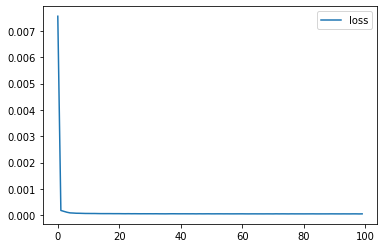

            predictions
2023-04-29     0.987836
2023-04-30     0.986782
2023-05-01     0.985351


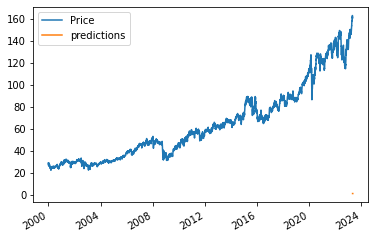

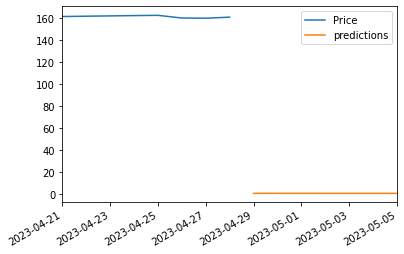

In [195]:
# Entrainement sur l'ensemble des données d'entrainement
print('-> création du modèle avec les paramètres ci-après:')
print(' early_stop: monitor:',monitor,', patience:',patience)
print('n_features: ',n_features)
print('epochs: ',n_epochs,'\n')

model.fit(generator, epochs=n_epochs,
        callbacks=[early_stop]) #, verbose=0)

# Evaluate the model on the test data
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.show()

#mse, test_data_2 = evaluate_model_rnn(model, test_data, scaled_train, length, n_features, scaler)

# nombre de valeurs à prédire
periods = 7 
# les dates associées en partant du 1er jour qui suit le dernier jour des train
pred_index = pd.date_range(start=(pd.to_datetime(max(train_data.index)) + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), periods=periods, freq='D')

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

valeurs_predites = []

for i in range(periods):
    # prediction avec 1 periode d'avance
    current_pred = model.predict(current_batch)[0]

    # stocker la prédiction
    valeurs_predites.append(current_pred) 

    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)        

predictions = pd.DataFrame(data=valeurs_predites, index=pred_index, columns=['predictions'])
print(predictions.head(3))


# Save the trained model
model.save("./models/full_trained_model.h5")

# Save the test data
dump(length, './data/length.joblib')
dump(n_features, './data/n_features.joblib')
dump(scaled_train, './data/full_scaled_train.joblib')        
dump(scaler, './data/scaler_full.joblib')

# tracer les données avec les prédictions sur la même courbe
ax = train_data.plot()
predictions.plot(ax=ax)
plt.show()                

# tracer les données avec les prédictions sur la même courbe (ZOOMER sur 10 jours avant et periods jours apres)
ax = train_data.plot()
predictions.plot(ax=ax)
debut_zoom = (pd.to_datetime(max(train_data.index)) - pd.Timedelta(days=7))
fin_zoom =  (pd.to_datetime(max(train_data.index)) + pd.Timedelta(days=periods))
plt.xlim(debut_zoom, fin_zoom)
plt.show()

Graphique

In [30]:
df.head(2)

Open       High        Low      Close  Adj Close     Volume
2000-01-03  28.805216  30.005434  28.736633  28.976677  16.351425  1094181.0
2000-01-04  28.976677  28.925238  26.953453  27.690729  15.625772  1671548.0

In [33]:
df["Date"] = pd.to_datetime(df.Date)

Timestamp('2000-01-03 00:00:00')

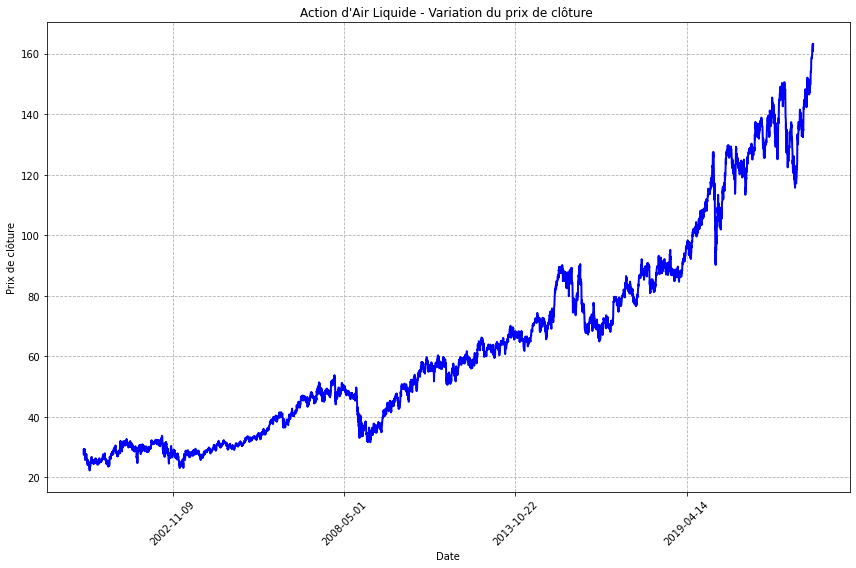

In [37]:
import matplotlib.pyplot as plt

# Définir les données à tracer
dates = df.index  # Assurez-vous que la colonne 'Date' est de type datetime
close_prices = df['Close']

# Créer la figure et les axes du graphique
fig, ax = plt.subplots(figsize=(12,8))

# Tracer le graphique
ax.plot(dates, close_prices, linewidth=2, color='blue')

# Ajouter des étiquettes et des titres
ax.set_xlabel('Date')
ax.set_ylabel('Prix de clôture')
ax.set_title('Action d\'Air Liquide - Variation du prix de clôture ')

# Formater les étiquettes de l'axe des dates
ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Affiche 6 étiquettes maximum
ax.xaxis.set_tick_params(rotation=45)  # Fait pivoter les étiquettes pour une meilleure lisibilité

# Afficher la grille en arrière-plan
ax.grid(True, linestyle='--')

# Afficher le graphique
plt.tight_layout()
plt.show()
